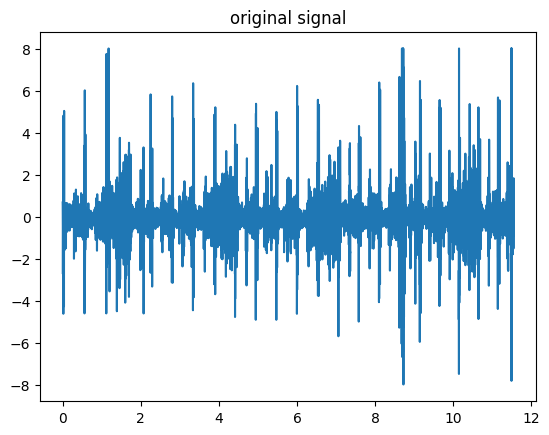

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from load_data import load_wav,pre_process


def down_sampling(data,samplerate,target_fre):
    factor = int(samplerate /target_fre)
    return int(samplerate/factor),data[::factor]
def plot_signal(data,title):
    plt.plot(np.linspace(0, len(data)/samplerate, len(data)), data)
    plt.title(title)
    plt.show()
    return
data_path='./data/23616_PV.wav'
target_fre=1000
samplerate, data = load_wav(data_path)
samplerate,data= down_sampling(data,samplerate,target_fre)
data= pre_process(data)
plot_signal(data,'original signal')
data_time_eva=data[2*samplerate:6*samplerate]

## Phase 1(reference sound detection)

### (A) periodicity in time domain

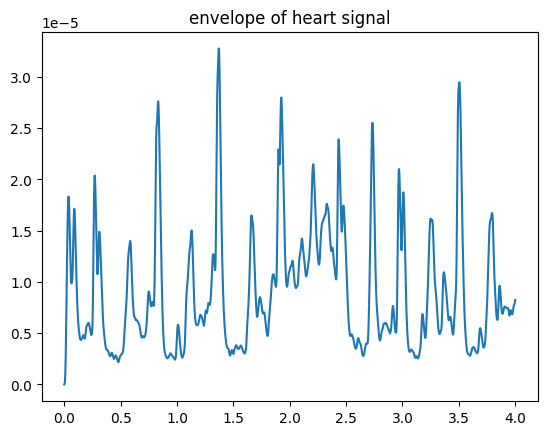

In [5]:
# extract envelop of HS components by Hilbert transform and Gammatone band-pass filter and auto correlation
from scipy.signal import hilbert
from envelope import filter,normalized_correlation


envelope=np.abs(hilbert(data_time_eva))
envelope=np.abs(filter(T=1/samplerate,input=envelope,freq_low=0,freq_high=500))
plot_signal(envelope,'envelope of heart signal')

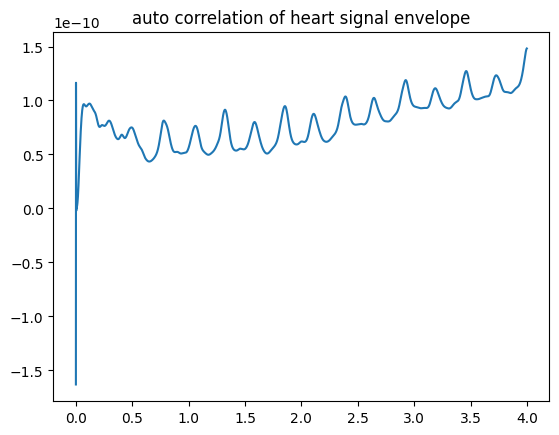

In [6]:
win=np.hanning(envelope.shape[0])
corr=normalized_correlation(envelope,win)
corr=corr[0:int(len(corr)/2)]
plot_signal(corr,'auto correlation of heart signal envelope')

In [7]:
# heart rate estimation using SVD
from scipy.linalg import svd
def SVD_eva(m):
    theta=svd(m,compute_uv=False)
    phi=(theta[1]/theta[0])**2
    return phi
def reshape_matrix(signal,n):
    m=len(signal) // n
    return [signal[i * n : (i + 1) * n] for i in range(m)]
def find_hr_SVD(signal,fs):
    low_period=0.4*fs
    high_period=1.2*fs
    min_phi=1
    est_period=0
    # coarse search
    for i in range(int(low_period),int(high_period+0.1*fs),int(0.1*fs)):
        stacked_signal=reshape_matrix(signal,i)
        tmp_phi=SVD_eva(stacked_signal)
        #print(tmp_phi,i/samplerate)
        if tmp_phi < min_phi:
            est_period=i
            min_phi=tmp_phi
    print("coarse search heart cycle ",est_period/fs,"s")
    # fine search
    low_period=(est_period/fs-0.1)*fs
    high_period=(est_period/fs+0.1)*fs
    for i in range(int(low_period),int(high_period+0.1*fs),int(0.01*fs)):
        stacked_signal=reshape_matrix(signal,i)
        tmp_phi=SVD_eva(stacked_signal)
        #print(tmp_phi,i/samplerate)
        if tmp_phi < min_phi:
            est_period=i
            min_phi=tmp_phi
    return est_period/fs

In [8]:
# heart rate estimation using single peak algorithm from "Robust Heart Rate Estimation from Noisy Phonocardiograms"
from scipy.signal import find_peaks
def find_hr_single_peak(signal,fs):
    low_period=int(60/140*fs)
    high_period=int(60/30*fs)
    peaks,property=find_peaks(signal[low_period:high_period])
    #print(peaks)
    highest_peak = peaks[np.argmax(signal[peaks])]
    highest_peak_value=signal[low_period:high_period][highest_peak]
    lag_time=(highest_peak+low_period)/fs
    return lag_time

In [9]:
# heart rate estimation using SVD, typical heart cycle 500-1200ms
#est_heart_cycle=60/find_hr_single_peak(corr,samplerate)
est_heart_cycle=find_hr_SVD(corr,samplerate)
print("Estimated heart cycle: ",est_heart_cycle,"s")

coarse search heart cycle  0.5 s
Estimated heart cycle:  0.56 s


- Periodicity check criterion 1

$$\cos(\theta) = \frac{\langle y_r(\tau), y_{r+1}(\tau) \rangle}{|y_r(\tau)| |y_{r+1}(\tau)|}$$

- It is considered that two consecutive heart cycles exhibit similar shapes if their internal product is greater than 0.8

[3.461, 2.924, 2.39, 1.853, 1.322, 0.779]


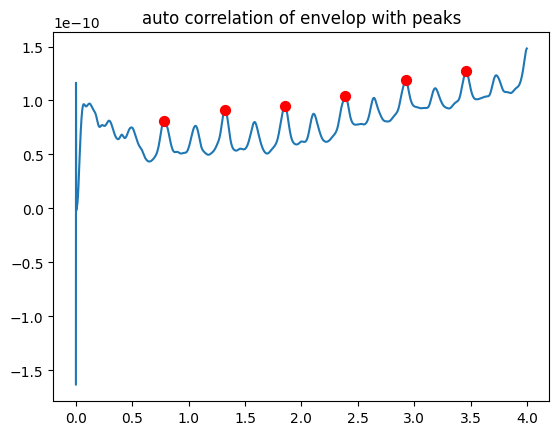

In [148]:
# select the prominent peaks
# use estimated heart rate from previous step
def find_promin_peaks(signal,fs,est_heart_cycle):

    window_size=int(fs*est_heart_cycle)
    num_heart_cycles = int(len(signal) /window_size)


    # trim start and end
    peaks,property=find_peaks(signal)
    for peak in peaks:
        if peak<window_size or peak >len(signal) - int(0.1 * fs):
            #print(peak)
            peaks=np.delete(peaks,np.where(peaks==peak))
    #print(peaks)
    highest_peak = peaks[np.argmax(signal[peaks])]

    selected_peaks = [highest_peak]


    def find_adjacent_peak(reference_peak, direction):
        if direction == -1:
            window_start, window_end = max(0, reference_peak - window_size), reference_peak
        else:
            window_start, window_end = reference_peak, min(len(signal), reference_peak + window_size)

        candidates = [p for p in peaks if (window_start < p < window_end) and (np.abs(p-reference_peak)>window_size/2)]
        if candidates:
            return max(candidates, key=lambda p: signal[p])
        return None


    for peak in selected_peaks:
        left_peak = find_adjacent_peak(peak, -1)
        #print(left_peak)
        if left_peak and left_peak not in selected_peaks:
            selected_peaks.append(left_peak)
            if len(selected_peaks) >= num_heart_cycles:
                break
        right_peak = find_adjacent_peak(peak, 1)
        if right_peak and right_peak not in selected_peaks:
            selected_peaks.append(right_peak)
            if len(selected_peaks) >= num_heart_cycles:
                break
    return selected_peaks

promin_peaks=find_promin_peaks(corr,samplerate,est_heart_cycle)
print([int(x)/samplerate for x in promin_peaks])
peak_indice=[int(x) for x in promin_peaks]

# plot peaks
plt.plot(np.linspace(0, len(corr)/samplerate, len(corr)), corr)
plt.title("auto correlation of envelop with peaks")
plt.scatter(np.linspace(0, len(data)/samplerate, len(data))[peak_indice], corr[peak_indice], color='red', s=50, label="Highlighted Points", zorder=3)
plt.show()

In [9]:
# checking for internal product
def cosine_similarity(y_r, y_r1):

    inner_product = np.dot(y_r, y_r1)
    norm_y_r = np.linalg.norm(y_r)
    norm_y_r1 = np.linalg.norm(y_r1)

    # Avoid division by zero
    if norm_y_r == 0 or norm_y_r1 == 0:
        return 0  # Or handle as needed

    return inner_product / (norm_y_r * norm_y_r1)

### Periodicity in time-frequency domain

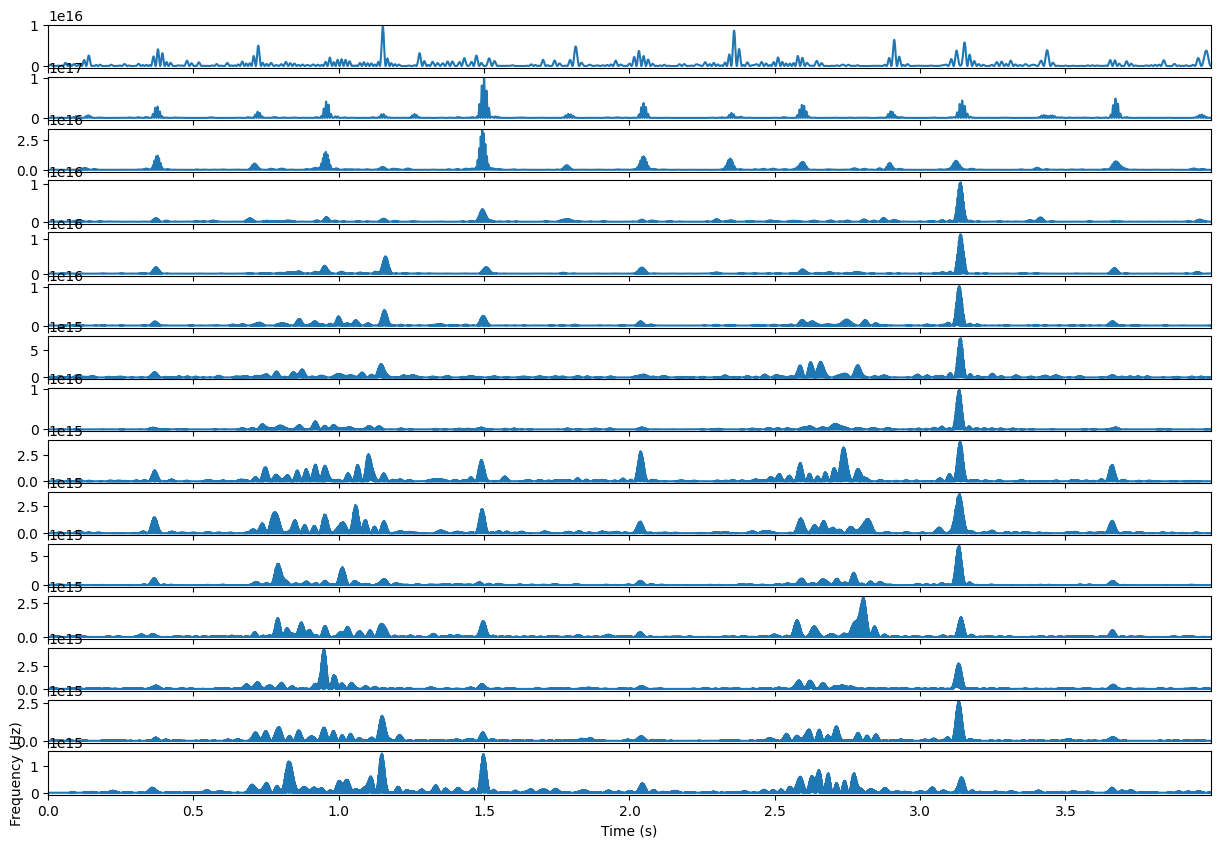

In [10]:
# STFT for the signal(with window function) and divide into 15 frequency bands in 0-600Hz and calculate spectral energy
from scipy.signal import ShortTimeFFT
def fre_bands_spectrum(signal,fs):
    N=len(signal)
    x=np.linspace(0, N - 1, N)
    win_temp=np.hanning(N)
    win=np.array([0 if idx > N / 2 else x for x,idx in enumerate(win_temp)])
    SFT=ShortTimeFFT(win=win,fs=fs,hop=1)
    STFT=np.real(SFT.stft(signal))
    y_lo=int((STFT.shape[1]+1)/4)
    y_hi=int((STFT.shape[1])*0.75)
    temp=STFT[:2400,y_lo:y_hi]
    fre_bands=temp.reshape(15,160,temp.shape[1]).sum(axis=1)
    fig, axes = plt.subplots(15, 1, figsize=(15, 10), sharex=True)

    for i in range(15):
        fre_bands[i]=[j**2 for j in fre_bands[i]]
        axes[i].plot(np.linspace(0,fre_bands.shape[1]/samplerate,fre_bands.shape[1]),fre_bands[i], label=f"Row {i+1}")
        plt.xlim(0,fre_bands.shape[1]/samplerate)
    axes[-1].set_xlabel("Time (s)")
    axes[-1].set_ylabel("Frequency (Hz)")
    plt.savefig("frebands.png")
    plt.show()

    return fre_bands

a=fre_bands_spectrum(data_time_eva,samplerate)

In [12]:
# auto correlation of each frequency band
as_k_len=2*a.shape[1]-1
as_k = np.zeros((15,as_k_len))
sg_1=np.zeros((5,a.shape[1]))
sg_6=np.zeros((5,a.shape[1]))
sg_11=np.zeros((5,a.shape[1]))
phi_sg=np.zeros(3)
for i in range(15):
    as_k[i]=np.correlate(a[i],a[i],mode="full")
    if i<=4:
        sg_1[i]=as_k[i][:a.shape[1]]
    elif i<=9:
        sg_6[i-5]=as_k[i][:a.shape[1]]
    else :
        sg_11[i-10]=as_k[i][:a.shape[1]]
phi_sg=[SVD_eva(sg_1),SVD_eva(sg_6),SVD_eva(sg_11)]
print([float(x) for x in phi_sg])


[0.0018167025189109157, 0.046284906847908584, 0.04704191927840567]


In [13]:
## peak alignment

num_of_peaks=int(a.shape[1]/samplerate/0.8)
peaks_in_fre_bands=np.zeros((15,num_of_peaks))
for i in range(15):
    peaks_in_fre_bands[i]=find_promin_peaks(as_k[i][:a.shape[1]],samplerate,0.8,0)

num_of_aligned_peaks=0
for j in range(num_of_peaks):
    flag=0
    standard=peaks_in_fre_bands[0][j]
    low_limit=standard*0.95
    high_limit=standard*1.05
    for k in range(1,15):
        if peaks_in_fre_bands[k][j] < low_limit or peaks_in_fre_bands[k][j] > high_limit:
            flag=1
            break
    if flag==0:
        num_of_aligned_peaks=num_of_aligned_peaks+1
print(num_of_aligned_peaks)

1
